# Get Mask RCNN

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (558/558), done.


Editar Mask_RCNN/mrcnn/model.py en la linea 2199:

```python
#self.keras_model.metrics_tensors.append(loss)
self.keras_model.metrics.append(loss)
```

In [ ]:
!cp -R /content/Mask_RCNN/mrcnn /content/

# Import libraries

In [ ]:
import os
import re
import sys
import math
import time
import json
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install --upgrade h5py==2.10.0
!pip install -U scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.5 MB 1.2 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [ ]:
import skimage
import skimage.draw
from skimage.io import imread
skimage.__version__

'0.16.2'

In [ ]:
!pip install tensorflow==1.15.2
!pip install tensorflow-gpu==1.15.0
!pip install q keras==2.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 1.2 MB/s 
     |████████████████████████████████| 3.8 MB 53.8 MB/s 
     |████████████████████████████████| 503 kB 57.4 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a15edb354d2fe410b82e924999900cf05387aec5d773bb8f802d8ec536c6ad45
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting u

In [ ]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [ ]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

Using TensorFlow backend.


In [ ]:
path_raiz = os.path.abspath('/content/Mask_RCNN')

# Dataset

In [ ]:
!unzip balloon_dataset.zip

Archive:  balloon_dataset.zip
   creating: balloon/
   creating: balloon/train/
  inflating: balloon/train/via_region_data.json  
   creating: __MACOSX/
   creating: __MACOSX/balloon/
   creating: __MACOSX/balloon/train/
  inflating: __MACOSX/balloon/train/._via_region_data.json  
  inflating: balloon/train/53500107_d24b11b3c2_b.jpg  
  inflating: __MACOSX/balloon/train/._53500107_d24b11b3c2_b.jpg  
  inflating: balloon/train/120853323_d4788431b9_b.jpg  
  inflating: __MACOSX/balloon/train/._120853323_d4788431b9_b.jpg  
  inflating: balloon/train/126700562_8e27720147_b.jpg  
  inflating: __MACOSX/balloon/train/._126700562_8e27720147_b.jpg  
  inflating: balloon/train/145053828_e0e748717c_b.jpg  
  inflating: __MACOSX/balloon/train/._145053828_e0e748717c_b.jpg  
  inflating: balloon/train/154446334_5d41cd1375_b.jpg  
  inflating: __MACOSX/balloon/train/._154446334_5d41cd1375_b.jpg  
  inflating: balloon/train/155815494_800fc9aa32_b.jpg  
  inflating: __MACOSX/balloon/train/._155815494_8

In [ ]:
class DatasetPersonalizado(utils.Dataset):

    def load_object(self, dataset_dir, subset, nome_annotation="via_region_data.json"):
        """Carrega um subconjunto do dataset Balloon.
        dataset_dir: Diretorio raíz do dataset.
        subset: Subconjunto a ser carregado: train (treinamento) ou val (validação)
        """
        # Adiciona as classes. Nesse exemplo, temos apenas uma classe para adicionar.
        self.add_class("objetos", 1, "balloon")

        # Escolhe se é o dataset de Treinamento ou Validação 
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Carrega as anotações (annotations) 
        # VGG Image Annotator (Até a verão 1.6) salva cada imagem no formato: 
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # O que mais interessa para nós são as coordenadas x e y de cada região
        # Obs: No VIA 2.0, as regiões são salvas em forma de lista ao invés de dicionario.
        annotations = json.load(open(os.path.join(dataset_dir, nome_annotation)))
        annotations = list(annotations.values())  # não precisa das dict keys

        # A ferramenta VIA salva as imagens em JSON mesmo que elas não contenham nenhuma anotação. Então, pulamos as imagens não anotadas.
        annotations = [a for a in annotations if a['regions']]

        contagem = 0
        # Adiciona as imagens
        for a in annotations:
            # Pega as coordenadas x e y dos pontos dos poligonos que formam o contorno de cada instância do objeto. 
            # Eles são armazenadas em shape_attributes (para visualizar, abra o arquivo json)
            # A condição if é necessária para que o código suporte anotações geradas pelas versões 1.x e 2.x da VIA.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # A função load_mask() vai precisar do tamanho da imagem para que possa converter os polígonos em mascaras.
            # Infelizmente, o VIA não inclui isso no JSON, então devemos ler a imagem manualmente e gerar essas máscaras.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            contagem = contagem+1

            self.add_image("objetos",
                image_id=a['filename'],  # usa o nome do arquivo como id unico da imagem
                path=image_path,
                width=width, height=height,
                polygons=polygons)
            
        print("Imagens "+subset+": " + str(contagem))

    def load_mask(self, image_id):
        """Gera as mascaras das instâncias para a imagem.
       Returna:
        masks: Uma array booleana de formato/shape [height, width, instance count] com 1 mascara por instancia.
        class_ids: uma array de 1D contendo os IDs das mascaras das instancias.
        """
        # Se não for uma imagem de conjunto de dados do balão (balloon dataset), delegue à classe ascendente.
        image_info = self.image_info[image_id]
        #print(image_info)
        if image_info["source"] != "objetos":
            return super(self.__class__, self).load_mask(image_id)

        # Converte os poligonos em uma mascara bitmap com shape  [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        # Agora será calculado a máscara da instância. para cada pixel da imagem, classificará como pertencente à classe ou não
        for i, p in enumerate(info["polygons"]):
            # Pega os indices dos pixels dentro dos poligonos e define eles como = 1 (cor branca), caso contrário continuará valor 0 (cor preta)
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape) # passamos o .shape também como 3ª parâmetro para evitar possíveis erros
            
            ## Obs: para esse dataset a anotação foi feita usando formas poligonais. 
            ## Entretanto, caso tenha usado outras formas pela ferramenta VIA (circulos e elipses) deverá especificar isso no código, ficando assim
            #if p['name'] == 'polygon':
            #  rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape)            
            #elif p['name'] == 'circle':
            #  rr, cc = skimage.draw.circle(p['cx'], p['cy'], p['r'])
            #else: 
            #  rr, cc = skimage.draw.ellipse(p['cx'], p['cy'], p['rx'], p['ry'], rotation=np.deg2rad(p['theta']))  

            mask[rr, cc, i] = 1

        # Retorna a mascara e a array dos IDs das classes de cada instancia. 
        # Como nesse exemplo temos uma classe apenas, retornamos uma array composta de 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Retorna o caminho da imagem."""
        info = self.image_info[image_id]
        if info["source"] == "objetos":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [ ]:
nome_annotation = 'via_region_data.json'
path_dataset = "/content/balloon/"
# Conjunto de treinamento
dataset_train = DatasetPersonalizado()
dataset_train.load_object(path_dataset, 'train', nome_annotation)
dataset_train.prepare()

Imagens train: 61


In [ ]:
# Conjunto de validação
dataset_val = DatasetPersonalizado()
dataset_val.load_object(path_dataset, 'val', nome_annotation)
dataset_val.prepare()

Imagens val: 13


# Check dataset

In [ ]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(img)
  plt.show()

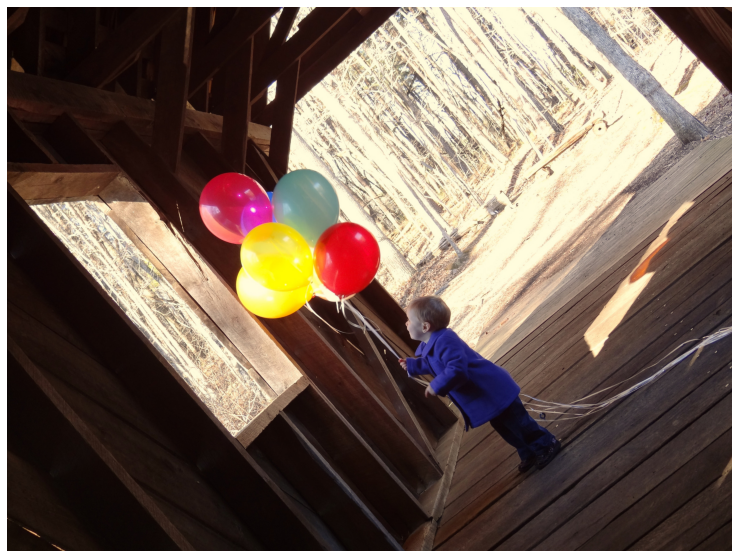

In [ ]:
img_id = 7
img = dataset_train.load_image(img_id)
mostrar(img)

In [ ]:
mask, class_ids = dataset_train.load_mask(img_id)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
class_ids

array([1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
mask, np.unique(mask, return_counts=True)

(array([[[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         ...,
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],
 
        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         ...,
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],
 
        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         ...,
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]

In [ ]:
dataset_train.class_names

['BG', 'balloon']

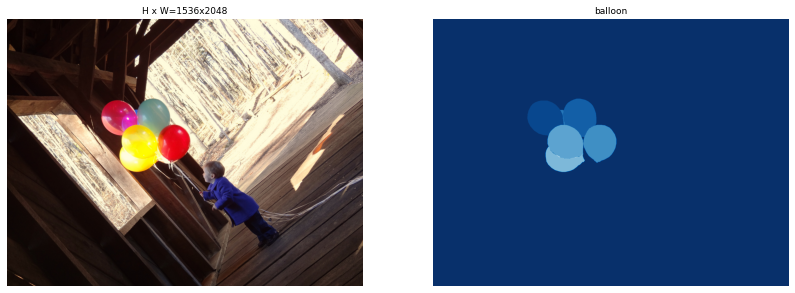

In [ ]:
visualize.display_top_masks(img, mask, class_ids, dataset_train.class_names, 1)

In [ ]:
dataset_train.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


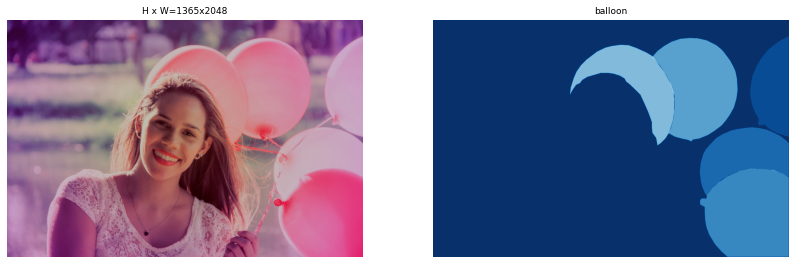

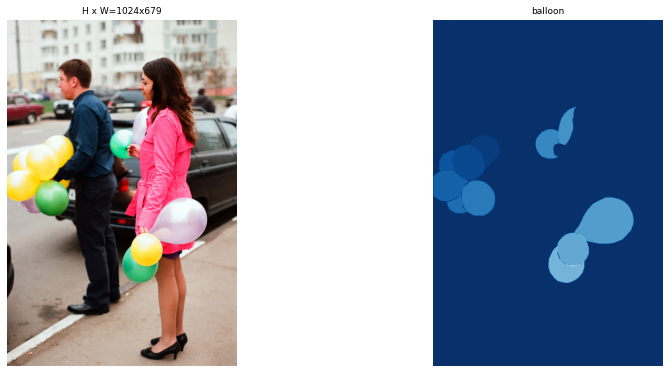

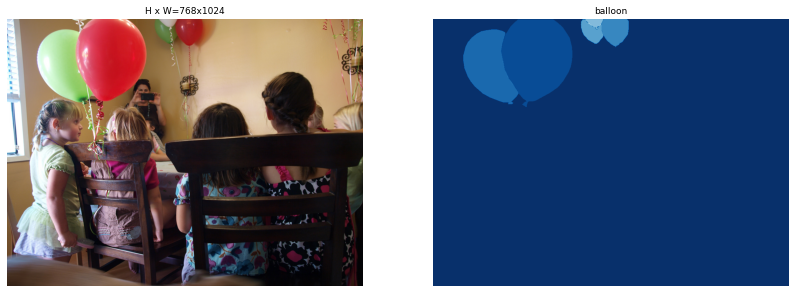

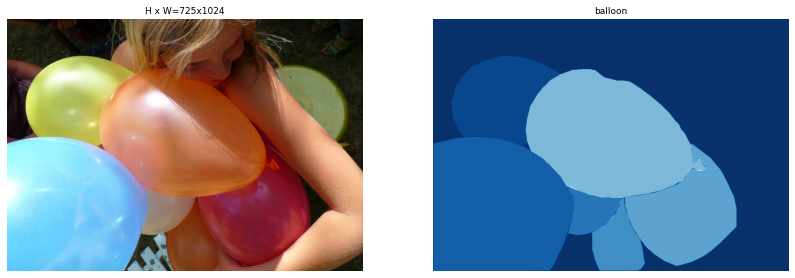

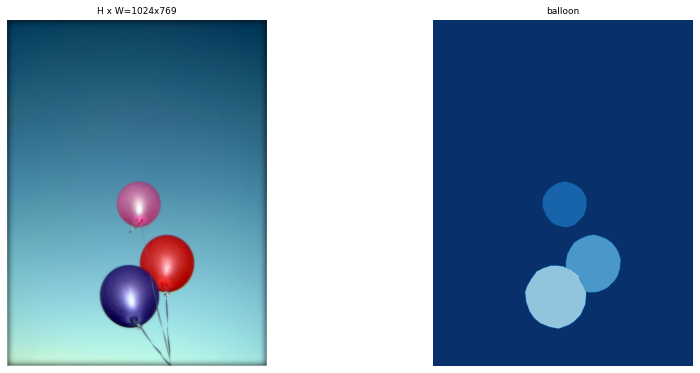

In [ ]:
img_ids = np.random.choice(dataset_train.image_ids, 5)
for img_id in img_ids:
  img = dataset_train.load_image(img_id)
  mask, class_ids = dataset_train.load_mask(img_id)
  visualize.display_top_masks(img, mask, class_ids, dataset_train.class_names, 1)

In [ ]:
img_id = 7
img = dataset_train.load_image(img_id)
mask, class_ids = dataset_train.load_mask(img_id)
bbox = utils.extract_bboxes(mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
bbox

array([[ 469,  542,  670,  750],
       [ 458,  748,  680,  940],
       [ 523,  731,  609,  762],
       [ 609,  864,  827, 1055],
       [ 609,  659,  803,  864],
       [ 734,  648,  880,  873]], dtype=int32)

In [ ]:
print('Imagem', img_id, dataset_train.image_reference(img_id))
log('image', img)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)

Imagem 7 /content/balloon/train/15717689633_5f7f78c28e_k.jpg
image                    shape: (1536, 2048, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1536, 2048, 6)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (6, 4)                min:  458.00000  max: 1055.00000  int32


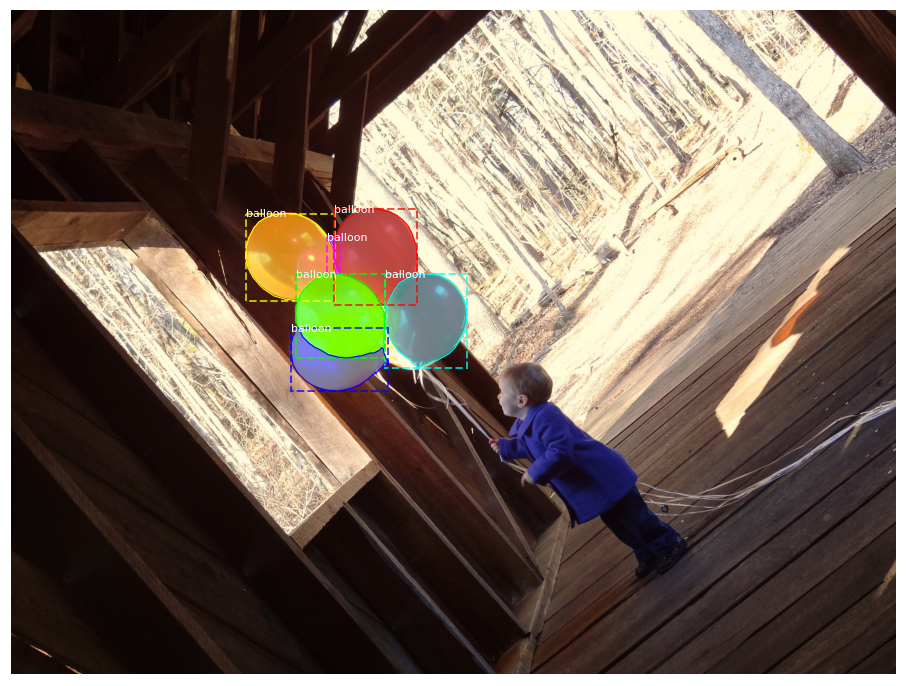

In [ ]:
visualize.display_instances(img, bbox, mask, class_ids, dataset_train.class_names, show_bbox=True)

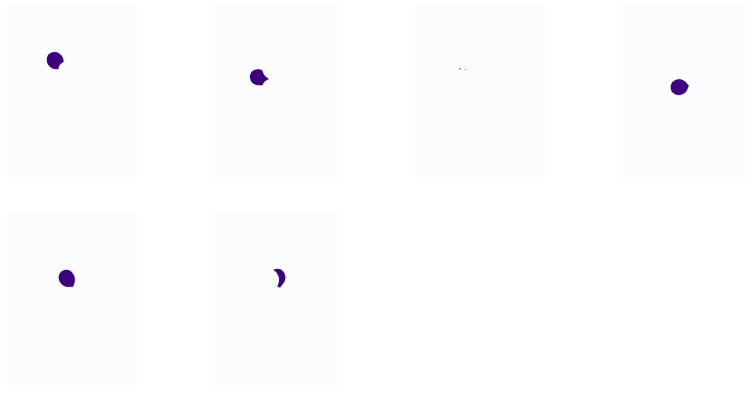

In [ ]:
visualize.display_images(np.transpose(mask), cmap='Purples')

# Config NN

In [ ]:
class ConfigRede(Config):
  NAME = 'balloon'
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 1
  STEPS_PER_EPOCH = 100
  DETECTION_MIN_CONFIDENCE = 0.9
config = ConfigRede()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
path_modelos = os.path.join(path_raiz, 'logs')
path_modelos

'/content/Mask_RCNN/logs'

# Transfer Learning

In [ ]:
# Transferência de aprendizagem
path_modelo_COCO = os.path.join(path_raiz, 'mask_rcnn_coco.h5')
path_modelo_COCO

'/content/Mask_RCNN/mask_rcnn_coco.h5'

In [ ]:
if not os.path.exists(path_modelo_COCO):
  utils.download_trained_weights(path_modelo_COCO)

... done downloading pretrained model!


In [ ]:
def carrega_modelo_treinamento(config, inicia_com = 'coco', model_path=''):
  model = modellib.MaskRCNN(mode = 'training', config = config, model_dir=model_path)
  if inicia_com == 'coco':
    model.load_weights(path_modelo_COCO, by_name = True, exclude = ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
  elif inicia_com == 'imagenet':
    model.load_weights(model.get_imagenet_weights(), by_name=True)
  elif inicia_com == 'last':
    if model_path == "":
      model_path = model.find_last()
    model.load_weights(model_path, by_name=True)

  return model

In [ ]:
model = carrega_modelo_treinamento(config, 'coco')






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








# Training

In [ ]:
!nvidia-smi

Mon Nov 14 15:28:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W /  70W |    102MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
inicio = time.time()
model.train(dataset_train, dataset_val, learning_rate = config.LEARNING_RATE, epochs = 25, layers='heads') # all
fim_treino = time.time()
minutos = round((fim_treino - inicio) / 60, 2)
print('Tempo de treinamento: ', minutos)


Starting at epoch 0. LR=0.001

Checkpoint Path: balloon20221114T1528/mask_rcnn_balloon_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistrib

AttributeError: ignored

In [ ]:
model.find_last()